<a href="https://www.kaggle.com/code/guilhermeparcerao/mafaulda-tinyml-training-for-fault-detection?scriptVersionId=204728929" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<h1>MAFAULDA TinyML Training for Fault Detection</h1>

In [1]:
!pip install ydf -U
import pandas as pd
import numpy as np
import tensorflow as tf
import ydf
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
from scipy.fft import rfft, rfftfreq
from scipy.integrate import cumtrapz
from sklearn.model_selection import StratifiedShuffleSplit
from os.path import join
from os import walk
from zipfile import ZipFile
from gc import collect
from warnings import filterwarnings
from statsmodels.tools.sm_exceptions import InterpolationWarning
filterwarnings("ignore", category=InterpolationWarning)
filterwarnings("ignore", category=FutureWarning)
filterwarnings("ignore", category=RuntimeWarning)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 54.7 MB/s eta 0:00:00


2024-11-01 20:16:35.860411: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-01 20:16:35.860543: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-01 20:16:35.989543: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


<h2>Database load and creation</h2>

Legend according to [MAFAULDA docs](https://www02.smt.ufrj.br/~offshore/mfs/page_01.html):

* Column 1: tachometer signal that allows to estimate rotation frequency;
* Columns 2 to 4: underhang bearing accelerometer (axial, radiale tangential direction);
* Columns 5 to 7: overhang bearing accelerometer (axial, radiale tangential direction);
* Column 8: microphone.

Custom classification legend:

* 0: normal;
* 1: horizontal misalignment;
* 2: vertical misalignment;
* 3: imbalance;

In [2]:
df_normal = pd.read_csv('/kaggle/input/mafaulda-full/mafaulda/normal/12.288.csv', names=['rot_freq', 'uhang_x', 'uhang_y', 'uhang_z', 'ohang_x', 'ohang_y', 'ohang_z', 'microphone'])
df_normal['class'] = 0
df_normal.reset_index(inplace=True, drop=True)
df_normal

rot_freq   uhang_x   uhang_y   uhang_z   ohang_x   ohang_y   ohang_z  \
0        4.55950  0.175200  0.287210 -0.017751 -0.415650  0.032459 -0.112180   
1        4.60380 -0.051295 -0.194050 -0.060071 -0.418090  0.036547 -0.110430   
2        4.57030 -0.969080  0.038033 -0.028329 -0.430810  0.041924 -0.143310   
3        4.58700  0.891270  0.072973  0.007453 -0.400170  0.041090 -0.119840   
4        4.58870 -1.716000 -0.329290 -0.033063 -0.502810  0.040474 -0.252700   
...          ...       ...       ...       ...       ...       ...       ...   
249995  -0.33352 -0.767530 -0.383180 -0.065833  0.052855 -0.000624  0.033041   
249996  -0.43764  0.125980  0.225880 -0.009517  0.106850  0.000140  0.088866   
249997  -0.26109  0.118680 -0.225380 -0.063392  0.043998 -0.000380  0.042475   
249998  -0.45957 -0.793080 -0.105010 -0.051047  0.037756  0.004440 -0.000873   
249999  -0.24359  1.002700  0.109100 -0.018489  0.169610  0.003927  0.120810   

        microphone  class  
0        -0.128140      0  
1         0.118310      0  
2        -0.071527      0  
3         0.043445      0  
4         0.023901      0  
...            ...    ...  
249995    0.114490      0  
249996   -0.145510      0  
249997    0.125850      0  
249998   -0.060454      0  
249999    0.011246      0  

[250000 rows x 9 columns]

In [3]:
df_hmis = pd.read_csv('/kaggle/input/mafaulda-full/mafaulda/horizontal-misalignment/0.5mm/12.288.csv', names=['rot_freq', 'uhang_x', 'uhang_y', 'uhang_z', 'ohang_x', 'ohang_y', 'ohang_z', 'microphone'])   
df_hmis['class'] = 1
df_hmis.reset_index(inplace=True, drop=True)
df_hmis

rot_freq  uhang_x   uhang_y   uhang_z  ohang_x   ohang_y  ohang_z  \
0       -0.49977  0.97159  0.086419 -0.017590  0.64014  0.194930  0.35288   
1       -0.54833 -1.21600 -0.353530 -0.060630  0.50864  0.195880  0.23587   
2       -0.44806  1.33940  0.285630  0.064970  0.65422  0.196410  0.37791   
3       -0.57483 -1.25120 -0.474590  0.016734  0.47286  0.192980  0.21212   
4       -0.45559  0.84107  0.314980  0.124230  0.62664  0.194600  0.36869   
...          ...      ...       ...       ...      ...       ...      ...   
249995  -0.53831 -0.50245 -0.195440 -0.127690 -1.13020  0.099213 -0.34438   
249996  -0.53883 -0.56453  0.114550 -0.067111 -1.12290  0.097333 -0.33685   
249997  -0.53620  0.52067 -0.008407 -0.023910 -1.09200  0.097712 -0.30687   
249998  -0.53906 -1.43360 -0.164980 -0.029434 -1.16960  0.094124 -0.39762   
249999  -0.53617  1.22350  0.235220  0.074932 -1.03370  0.095170 -0.27669   

        microphone  class  
0         0.021614      1  
1         0.045124      1  
2        -0.070311      1  
3         0.124980      1  
4        -0.133050      1  
...            ...    ...  
249995    0.171440      1  
249996   -0.075835      1  
249997    0.090173      1  
249998    0.071409      1  
249999   -0.050913      1  

[250000 rows x 9 columns]

In [4]:
df_vmis = pd.read_csv('/kaggle/input/mafaulda-full/mafaulda/vertical-misalignment/0.51mm/12.4928.csv', names=['rot_freq', 'uhang_x', 'uhang_y', 'uhang_z', 'ohang_x', 'ohang_y', 'ohang_z', 'microphone'])
df_vmis['class'] = 2
df_vmis.reset_index(inplace=True, drop=True)
df_vmis

rot_freq  uhang_x   uhang_y   uhang_z   ohang_x   ohang_y  ohang_z  \
0       -0.48787 -1.48880 -1.226100 -0.053115  0.087754 -0.019895 -0.34386   
1       -0.57974 -1.78140 -0.043469 -0.019549  0.088069 -0.021044 -0.34816   
2       -0.46808  0.34146 -0.506220 -0.038985  0.107870 -0.015602 -0.33184   
3       -0.54623 -3.57540 -0.523980 -0.111900  0.056284 -0.012239 -0.37779   
4       -0.52265  1.33660  0.126860 -0.030031  0.119580 -0.010847 -0.31540   
...          ...      ...       ...       ...       ...       ...      ...   
249995   4.52640  0.17957  0.328640  0.005930 -0.723270  0.046866 -0.45728   
249996   4.56150  0.60053  0.304340 -0.003877 -0.723650  0.046353 -0.45282   
249997   4.54240 -0.47440  0.298750 -0.014334 -0.777350  0.047360 -0.50109   
249998   4.54250  1.33940  0.380970  0.017293 -0.729550  0.047963 -0.46352   
249999   4.56280 -1.24860  0.129880 -0.062306 -0.798410  0.050550 -0.54332   

        microphone  class  
0         0.348540      2  
1        -0.056170      2  
2         0.180420      2  
3         0.147590      2  
4        -0.054272      2  
...            ...    ...  
249995   -0.047993      2  
249996    0.072967      2  
249997    0.022733      2  
249998   -0.003479      2  
249999    0.164840      2  

[250000 rows x 9 columns]

In [5]:
df_imb = pd.read_csv('/kaggle/input/mafaulda-full/mafaulda/imbalance/10g/13.9264.csv', names=['rot_freq', 'uhang_x', 'uhang_y', 'uhang_z', 'ohang_x', 'ohang_y', 'ohang_z', 'microphone'])
df_imb['class'] = 3
df_imb.reset_index(inplace=True, drop=True)
df_imb

rot_freq  uhang_x   uhang_y   uhang_z  ohang_x   ohang_y   ohang_z  \
0        4.56710  1.54090  0.408130  0.048206  0.15618  0.034018  0.181940   
1        4.62520 -0.65002 -0.399110 -0.023339  0.15131  0.032407  0.109080   
2        4.56570  0.50367  0.417000  0.029059  0.15085  0.030508  0.194110   
3        4.62200  0.22507 -0.272730 -0.019793  0.14843  0.027678  0.150550   
4        4.57470 -0.26502  0.200050  0.004126  0.14428  0.026291  0.150640   
...          ...      ...       ...       ...      ...       ...       ...   
249995  -0.51767 -1.11350 -0.016405  0.025045  0.13796  0.057987 -0.157210   
249996  -0.52513  1.52230  0.289540  0.041841  0.14314  0.058507 -0.095435   
249997  -0.52000 -0.81701 -0.269480 -0.012067  0.14033  0.059348 -0.160110   
249998  -0.51963  1.27770  0.391690  0.037364  0.14198  0.058629 -0.081987   
249999  -0.52942 -0.16444 -0.301430 -0.013518  0.13745  0.059188 -0.155040   

        microphone  class  
0        -0.051011      3  
1        -0.029934      3  
2        -0.085132      3  
3         0.058802      3  
4        -0.070481      3  
...            ...    ...  
249995   -0.046094      3  
249996   -0.026089      3  
249997   -0.038306      3  
249998   -0.067828      3  
249999    0.054932      3  

[250000 rows x 9 columns]

In [6]:
df_raw_general = pd.concat([df_normal, df_hmis, df_vmis, df_imb])
df_raw_general.reset_index(inplace=True, drop=True)
df_raw_general

rot_freq   uhang_x   uhang_y   uhang_z  ohang_x   ohang_y   ohang_z  \
0        4.55950  0.175200  0.287210 -0.017751 -0.41565  0.032459 -0.112180   
1        4.60380 -0.051295 -0.194050 -0.060071 -0.41809  0.036547 -0.110430   
2        4.57030 -0.969080  0.038033 -0.028329 -0.43081  0.041924 -0.143310   
3        4.58700  0.891270  0.072973  0.007453 -0.40017  0.041090 -0.119840   
4        4.58870 -1.716000 -0.329290 -0.033063 -0.50281  0.040474 -0.252700   
...          ...       ...       ...       ...      ...       ...       ...   
999995  -0.51767 -1.113500 -0.016405  0.025045  0.13796  0.057987 -0.157210   
999996  -0.52513  1.522300  0.289540  0.041841  0.14314  0.058507 -0.095435   
999997  -0.52000 -0.817010 -0.269480 -0.012067  0.14033  0.059348 -0.160110   
999998  -0.51963  1.277700  0.391690  0.037364  0.14198  0.058629 -0.081987   
999999  -0.52942 -0.164440 -0.301430 -0.013518  0.13745  0.059188 -0.155040   

        microphone  class  
0        -0.128140      0  
1         0.118310      0  
2        -0.071527      0  
3         0.043445      0  
4         0.023901      0  
...            ...    ...  
999995   -0.046094      3  
999996   -0.026089      3  
999997   -0.038306      3  
999998   -0.067828      3  
999999    0.054932      3  

[1000000 rows x 9 columns]

<h2>Data validation and preparation</h2>

In [7]:
SAMPLE_RATE = 51200 # from MAFAULDA documentation

In [8]:
def test_stationarity(series):
    adf_result = adfuller(series)
    kpss_result = kpss(series, regression='c', nlags='auto')

    return {
        "adf_statistic": adf_result[0],
        "adf_pvalue": adf_result[1],
        "kpss_statistic": kpss_result[0],
        "kpss_pvalue": kpss_result[1],
    }

def plot_rolling_stats(final_df, axis):
    plt.figure(figsize=(10, 6))
    rolling_mean = final_df[axis].rolling(window=50).mean()
    rolling_variance = final_df[axis].rolling(window=50).var()
    plt.plot(final_df[axis], label=f'{axis} axis signal')
    plt.plot(rolling_mean, label='Rolling Mean', color='red')
    plt.plot(rolling_variance, label='Rolling Variance', color='green')
    plt.title(f'Rolling Mean & Variance - {axis} Axis (Final Result)')
    plt.legend()
    plt.show()

In [9]:
def accel_fft_spectrum(x_accel, y_accel, z_accel, n_samples):
    yf1 = rfft(x_accel - np.mean(x_accel))
    yf2 = rfft(y_accel - np.mean(y_accel))
    yf3 = rfft(z_accel - np.mean(z_accel))
    xf = rfftfreq(n_samples, 1 / SAMPLE_RATE)
    
    plt.plot(xf, np.abs(yf1), color='blue')
    plt.plot(xf, np.abs(yf2), color='green')
    plt.plot(xf, np.abs(yf3), color='yellow')
    
def vel_fft_spectrum(freq): 
    rad_per_sec = freq * (2 * (np.pi / 60))
    ang_vel = cumtrapz(y=rad_per_sec, dx=1 / SAMPLE_RATE)
    
    yf = rfft(ang_vel - np.mean(ang_vel))
    xf = rfftfreq(len(ang_vel), 1 / SAMPLE_RATE)
    
    plt.plot(xf, np.abs(yf), color='blue')

Result for isna test: False
Result for duplicated test: False


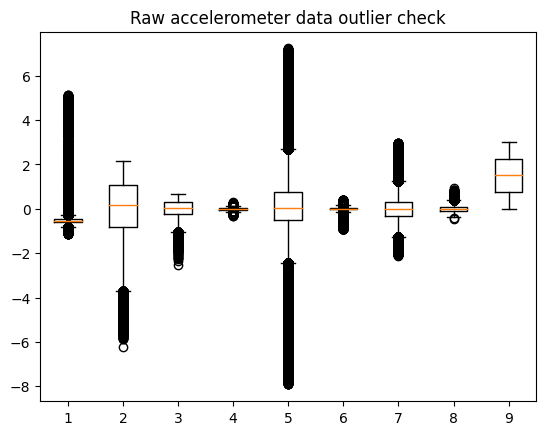

In [10]:
raw_general_isna = df_raw_general.isna().values.any()
raw_general_duplicated = df_raw_general.duplicated().values.any()
print(f"Result for isna test: {raw_general_isna}")
print(f"Result for duplicated test: {raw_general_duplicated}")
plt.title("Raw accelerometer data outlier check")
plt.boxplot(df_raw_general)
plt.show()


--- Final Stationarity Results ---
--- ohang_x axis ---
ADF Statistic: -5.860718029370478
ADF p-value: 0.007965443602321862
KPSS Statistic: 1.115426587046811
KPSS p-value: 0.04981697332269416
ADF Test indicates stationarity
KPSS Test indicates non-stationarity

--- ohang_y axis ---
ADF Statistic: -12.88058160769161
ADF p-value: 3.673738712026799e-06
KPSS Statistic: 0.21980270036430996
KPSS p-value: 0.09844626030124351
ADF Test indicates stationarity
KPSS Test indicates stationarity
--- ohang_z axis ---
ADF Statistic: -5.762031781016966
ADF p-value: 0.0004210228957908327
KPSS Statistic: 3.5087411260079007
KPSS p-value: 0.010000000000000002
ADF Test indicates stationarity
KPSS Test indicates non-stationarity

--- uhang_x axis ---
ADF Statistic: -18.729590990975858
ADF p-value: 3.2403224370623937e-25
KPSS Statistic: 0.15966729012894038
KPSS p-value: 0.09999999999999999
ADF Test indicates stationarity
KPSS Test indicates stationarity
--- uhang_y axis ---
ADF Statistic: -22.10811883676729


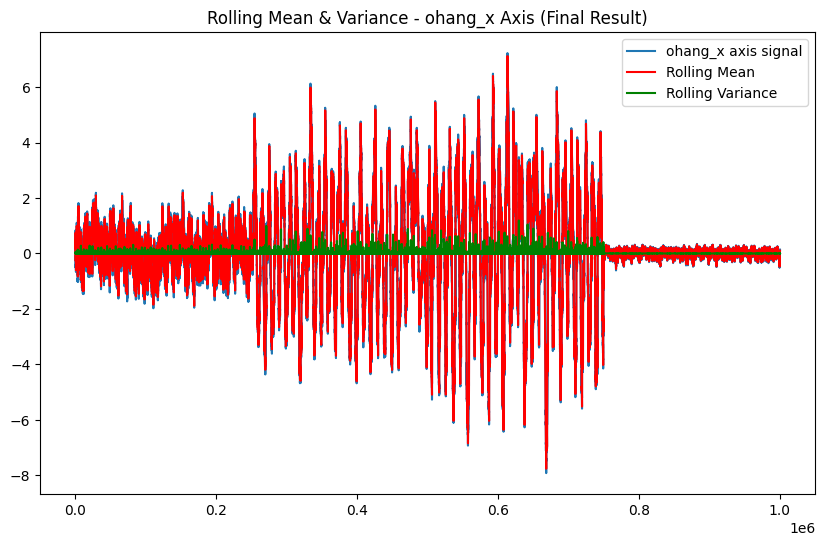

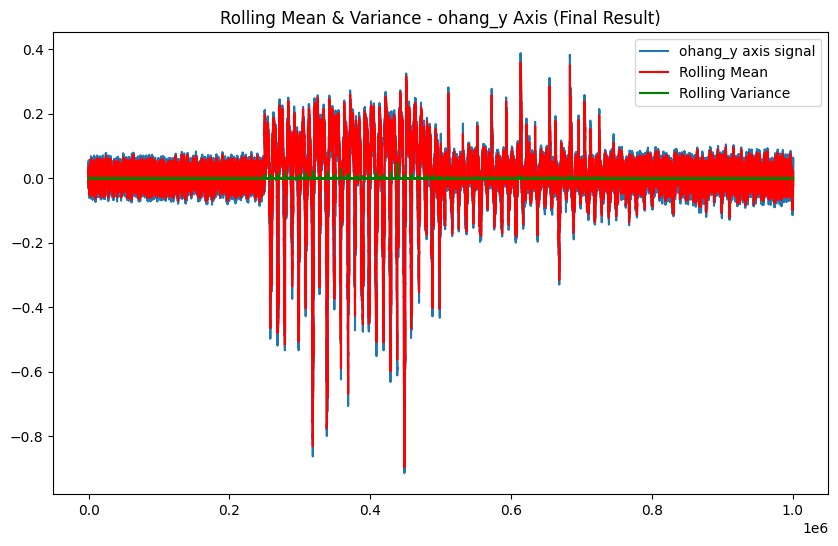

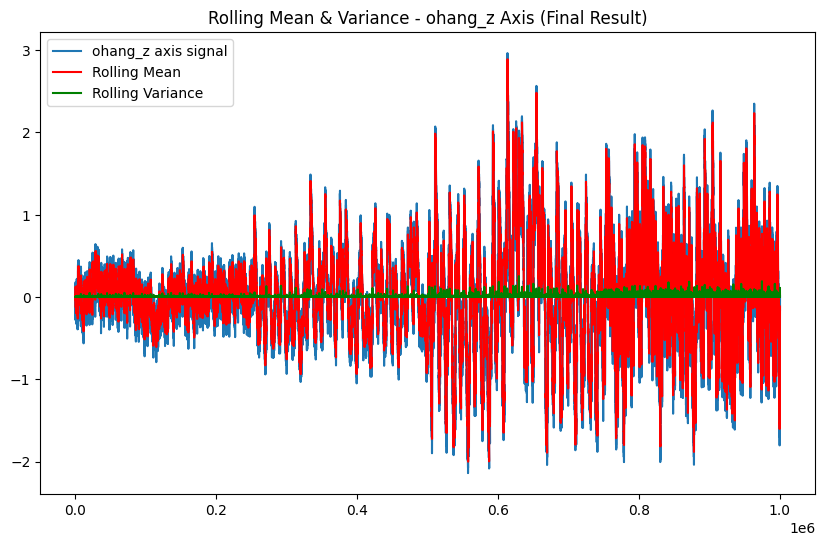

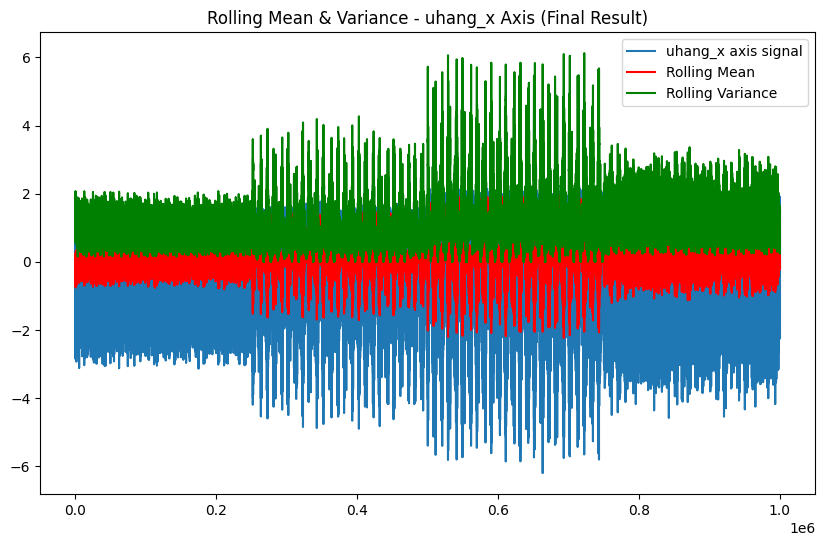

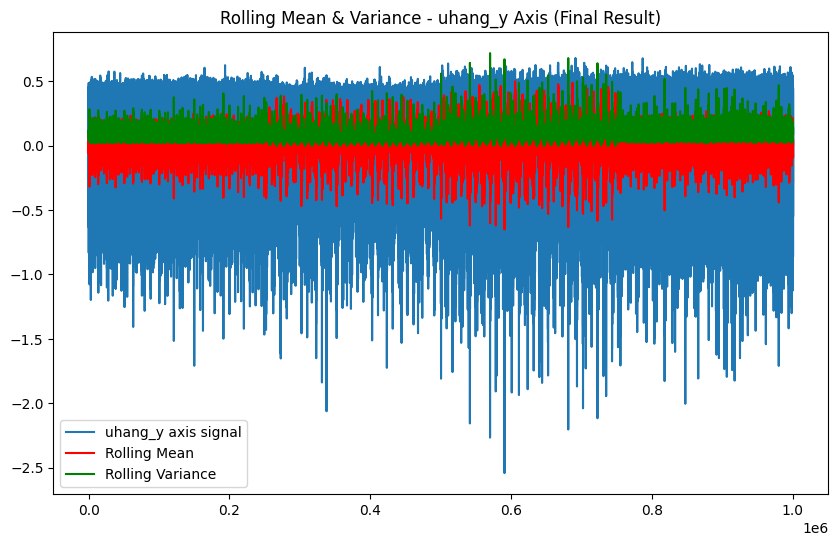

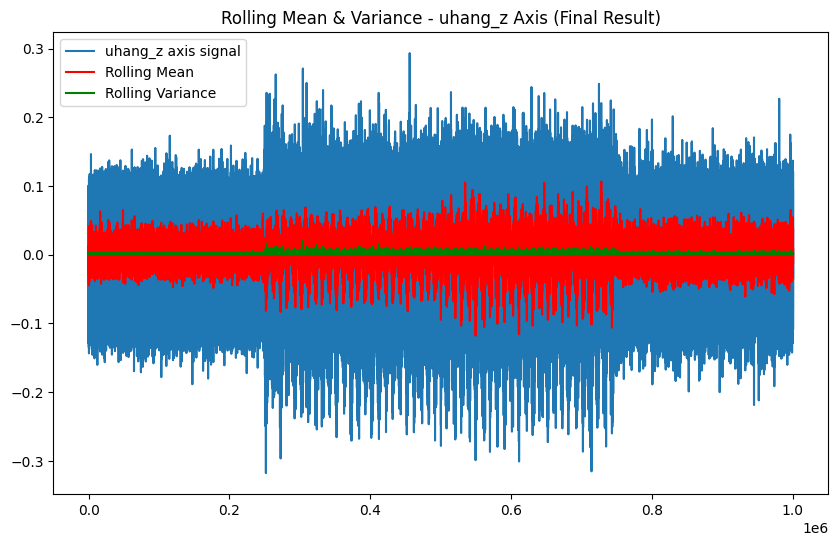

In [11]:
chunk_size = 100000
chunks = np.array_split(df_raw_general, np.ceil(len(df_raw_general) / chunk_size))
prev_chunk_end = None
final_df = pd.DataFrame()
stationarity_results = {axis: {"adf_statistic": 0, "adf_pvalue": 0, "kpss_statistic": 0, "kpss_pvalue": 0} for axis in ['ohang_x', 'ohang_y', 'ohang_z', 'uhang_x', 'uhang_y', 'uhang_z']}
n_chunks = len(chunks)

for i, chunk in enumerate(chunks):

    if prev_chunk_end is not None:
        chunk = pd.concat([prev_chunk_end, chunk], ignore_index=True)

    for axis in ['ohang_x', 'ohang_y', 'ohang_z', 'uhang_x', 'uhang_y', 'uhang_z']:
        test_results = test_stationarity(chunk[axis])
        stationarity_results[axis]["adf_statistic"] += test_results["adf_statistic"] / n_chunks
        stationarity_results[axis]["adf_pvalue"] += test_results["adf_pvalue"] / n_chunks
        stationarity_results[axis]["kpss_statistic"] += test_results["kpss_statistic"] / n_chunks
        stationarity_results[axis]["kpss_pvalue"] += test_results["kpss_pvalue"] / n_chunks

    prev_chunk_end = chunk.iloc[-50:]
    final_df = pd.concat([final_df, chunk], ignore_index=True)
    del chunk
    collect()

print("\n--- Final Stationarity Results ---")

for axis, results in stationarity_results.items():
    print(f"--- {axis} axis ---")
    print(f"ADF Statistic: {results['adf_statistic']}")
    print(f"ADF p-value: {results['adf_pvalue']}")
    print(f"KPSS Statistic: {results['kpss_statistic']}")
    print(f"KPSS p-value: {results['kpss_pvalue']}")
    print("ADF Test indicates stationarity" if results['adf_pvalue'] < 0.05 else "ADF Test indicates non-stationarity")
    print("KPSS Test indicates stationarity" if results['kpss_pvalue'] > 0.05 else "KPSS Test indicates non-stationarity\n")

for axis in ['ohang_x', 'ohang_y', 'ohang_z', 'uhang_x', 'uhang_y', 'uhang_z']:
    plot_rolling_stats(final_df, axis)

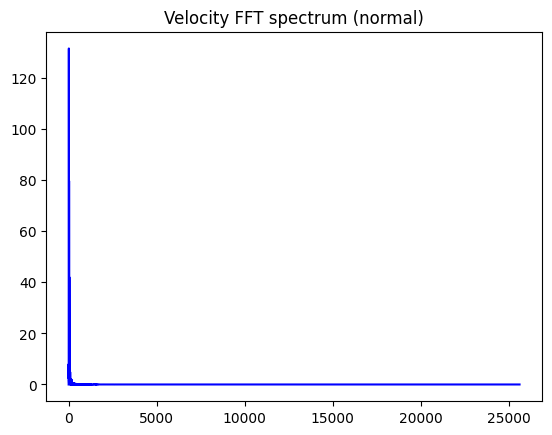

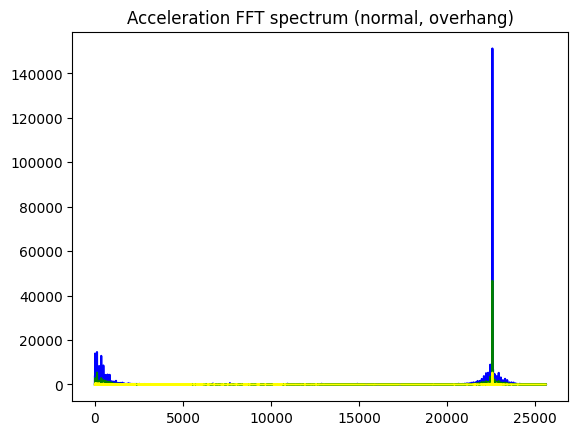

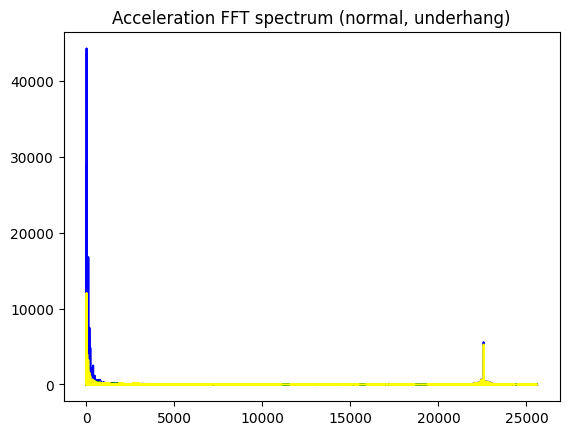

In [12]:
vel_fft_spectrum(df_normal.iloc[:,0].values)
plt.title("Velocity FFT spectrum (normal)")
plt.show()

accel_fft_spectrum(df_normal.iloc[:,1].values, df_normal.iloc[:,2].values, df_normal.iloc[:,3].values, df_normal.iloc[:,1].shape[0])
plt.title("Acceleration FFT spectrum (normal, overhang)")
plt.show()

accel_fft_spectrum(df_normal.iloc[:,4].values, df_normal.iloc[:,5].values, df_normal.iloc[:,6].values, df_normal.iloc[:,4].shape[0])
plt.title("Acceleration FFT spectrum (normal, underhang)")
plt.show()

In [13]:
freq = df_normal.iloc[:, 0].values
rad_per_sec = freq * (2 * (np.pi / 60))
ang_vel = cumtrapz(y=rad_per_sec, dx=1 / SAMPLE_RATE, initial=0)
ang_vel_fft = rfft(ang_vel - np.mean(ang_vel))

uhang_x = df_normal.iloc[:, 1].values
uhang_y = df_normal.iloc[:, 2].values
uhang_z = df_normal.iloc[:, 3].values
uhang_x_fft = rfft(uhang_x - np.mean(uhang_x))
uhang_y_fft = rfft(uhang_y - np.mean(uhang_y))
uhang_z_fft = rfft(uhang_z - np.mean(uhang_z))

ohang_x = df_normal.iloc[:, 4].values
ohang_y = df_normal.iloc[:, 5].values
ohang_z = df_normal.iloc[:, 6].values
ohang_x_fft = rfft(ohang_x - np.mean(ohang_x))
ohang_y_fft = rfft(ohang_y - np.mean(ohang_y))
ohang_z_fft = rfft(ohang_z - np.mean(ohang_z))

n_samples = df_normal.shape[0]
df_fft_normal = pd.DataFrame()

df_fft_normal['ang_vel_fft'] = np.abs(ang_vel_fft[:n_samples])

df_fft_normal['uhang_x_fft'] = np.abs(uhang_x_fft[:n_samples])
df_fft_normal['uhang_y_fft'] = np.abs(uhang_y_fft[:n_samples])
df_fft_normal['uhang_z_fft'] = np.abs(uhang_z_fft[:n_samples])

df_fft_normal['ohang_x_fft'] = np.abs(ohang_x_fft[:n_samples])
df_fft_normal['ohang_y_fft'] = np.abs(ohang_y_fft[:n_samples])
df_fft_normal['ohang_z_fft'] = np.abs(ohang_z_fft[:n_samples])

df_fft_normal['fftfreq'] = rfftfreq(n_samples, 1 / SAMPLE_RATE)
df_fft_normal['class'] = 0
df_fft_normal

ang_vel_fft   uhang_x_fft   uhang_y_fft   uhang_z_fft   ohang_x_fft  \
0       3.770638e-14  3.758771e-12  1.850964e-12  1.489919e-13  1.779910e-12   
1       5.556409e+00  7.527739e+02  6.554490e+01  1.561405e+01  2.123549e+04   
2       2.018688e+00  4.663129e+02  3.855406e+01  9.537433e+00  1.806313e+04   
3       3.377706e+00  2.038828e+02  3.335922e+01  3.331314e+00  1.626132e+04   
4       2.796448e+00  1.888168e+02  4.010503e+01  1.045659e+01  1.213880e+04   
...              ...           ...           ...           ...           ...   
124996  7.490713e-04  3.798164e+01  6.191380e+00  9.709779e-01  1.166566e+00   
124997  7.490715e-04  1.364614e+01  1.462490e+01  4.760959e-01  1.349532e+00   
124998  7.490711e-04  3.051517e+01  6.716724e+00  1.572614e+00  1.121919e+00   
124999  7.490712e-04  8.410264e+00  9.014265e+00  2.107842e+00  3.817953e+00   
125000  7.490713e-04  2.176522e+01  1.412917e+01  4.145741e-01  2.127103e+00   

         ohang_y_fft   ohang_z_fft     fftfreq  class  
0       9.769963e-15  1.326272e-12      0.0000      0  
1       5.131575e+01  1.120746e+04      0.2048      0  
2       7.927480e+01  9.896221e+03      0.4096      0  
3       9.321161e+01  5.844571e+03      0.6144      0  
4       4.212470e+01  4.858016e+03      0.8192      0  
...              ...           ...         ...    ...  
124996  5.231628e-01  1.015984e+00  25599.1808      0  
124997  9.782553e-01  1.304936e+00  25599.3856      0  
124998  1.124263e+00  1.144490e+00  25599.5904      0  
124999  1.442630e+00  2.990894e+00  25599.7952      0  
125000  1.138030e+01  1.919800e+00  25600.0000      0  

[125001 rows x 9 columns]

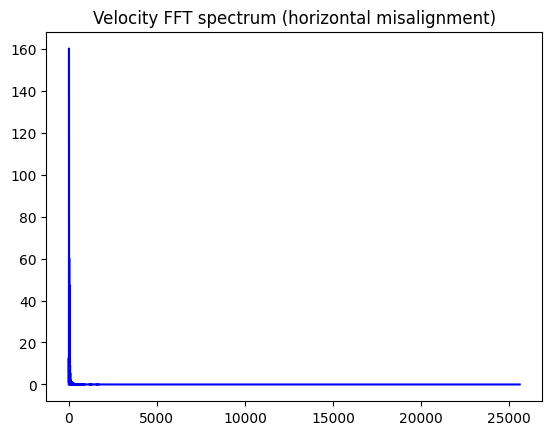

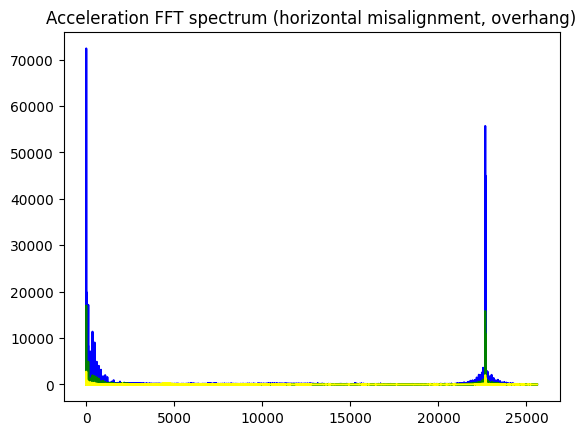

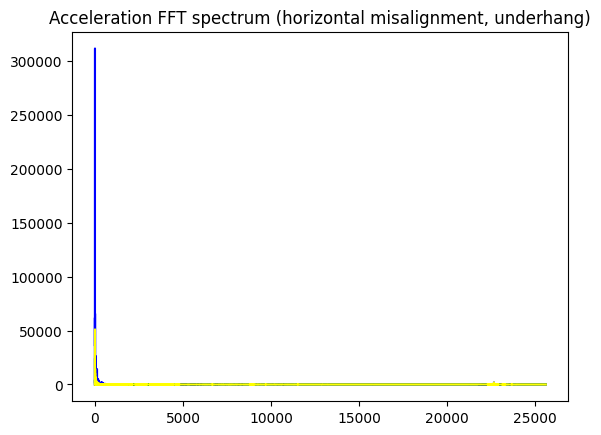

In [14]:
vel_fft_spectrum(df_hmis.iloc[:,0].values)
plt.title("Velocity FFT spectrum (horizontal misalignment)")
plt.show()

accel_fft_spectrum(df_hmis.iloc[:,1].values, df_hmis.iloc[:,2].values, df_hmis.iloc[:,3].values, df_hmis.iloc[:,1].shape[0])
plt.title("Acceleration FFT spectrum (horizontal misalignment, overhang)")
plt.show()

accel_fft_spectrum(df_hmis.iloc[:,4].values, df_hmis.iloc[:,5].values, df_hmis.iloc[:,6].values, df_hmis.iloc[:,4].shape[0])
plt.title("Acceleration FFT spectrum (horizontal misalignment, underhang)")
plt.show()

In [15]:
freq = df_hmis.iloc[:, 0].values
rad_per_sec = freq * (2 * (np.pi / 60))
ang_vel = cumtrapz(y=rad_per_sec, dx=1 / SAMPLE_RATE, initial=0)
ang_vel_fft = rfft(ang_vel - np.mean(ang_vel))

uhang_x = df_hmis.iloc[:, 1].values
uhang_y = df_hmis.iloc[:, 2].values
uhang_z = df_hmis.iloc[:, 3].values
uhang_x_fft = rfft(uhang_x - np.mean(uhang_x))
uhang_y_fft = rfft(uhang_y - np.mean(uhang_y))
uhang_z_fft = rfft(uhang_z - np.mean(uhang_z))

ohang_x = df_hmis.iloc[:, 4].values
ohang_y = df_hmis.iloc[:, 5].values
ohang_z = df_hmis.iloc[:, 6].values
ohang_x_fft = rfft(ohang_x - np.mean(ohang_x))
ohang_y_fft = rfft(ohang_y - np.mean(ohang_y))
ohang_z_fft = rfft(ohang_z - np.mean(ohang_z))

n_samples = df_hmis.shape[0]
df_fft_hmis = pd.DataFrame()

df_fft_hmis['ang_vel_fft'] = np.abs(ang_vel_fft[:n_samples])

df_fft_hmis['uhang_x_fft'] = np.abs(uhang_x_fft[:n_samples])
df_fft_hmis['uhang_y_fft'] = np.abs(uhang_y_fft[:n_samples])
df_fft_hmis['uhang_z_fft'] = np.abs(uhang_z_fft[:n_samples])

df_fft_hmis['ohang_x_fft'] = np.abs(ohang_x_fft[:n_samples])
df_fft_hmis['ohang_y_fft'] = np.abs(ohang_y_fft[:n_samples])
df_fft_hmis['ohang_z_fft'] = np.abs(ohang_z_fft[:n_samples])

df_fft_hmis['fftfreq'] = rfftfreq(n_samples, 1 / SAMPLE_RATE)
df_fft_hmis['class'] = 1
df_fft_hmis

ang_vel_fft   uhang_x_fft   uhang_y_fft   uhang_z_fft   ohang_x_fft  \
0       1.184057e-13  6.551204e-12  5.613288e-13  1.565414e-13  4.085621e-12   
1       7.288568e+00  8.090637e+02  1.340401e+02  2.260284e+01  1.730562e+03   
2       2.714095e+00  3.489973e+02  1.178304e+02  1.066038e+01  5.048697e+04   
3       1.268075e+01  2.068502e+03  4.306727e+02  6.847348e+01  1.507538e+04   
4       6.498937e+00  9.271250e+02  1.454183e+02  3.154939e+01  3.601094e+04   
...              ...           ...           ...           ...           ...   
124996  7.272114e-04  2.390556e+01  1.240867e+01  7.798653e-01  1.264400e+00   
124997  7.272114e-04  1.776986e+01  8.047493e+00  8.728408e-01  1.317834e+00   
124998  7.272117e-04  3.049889e+01  1.639047e+01  1.451931e+00  8.265372e-01   
124999  7.272115e-04  2.704280e+01  5.945664e+00  8.411236e-01  3.216947e+00   
125000  7.272114e-04  6.836566e+00  1.768311e+01  2.839067e+00  4.383050e+00   

         ohang_y_fft   ohang_z_fft     fftfreq  class  
0       1.168843e-12  4.263256e-14      0.0000      1  
1       2.738009e+02  6.168715e+03      0.2048      1  
2       1.188008e+03  1.557239e+04      0.4096      1  
3       7.962560e+02  8.055542e+03      0.6144      1  
4       2.012239e+03  6.376273e+03      0.8192      1  
...              ...           ...         ...    ...  
124996  4.273556e-01  6.871288e-01  25599.1808      1  
124997  1.478968e+00  1.560615e+00  25599.3856      1  
124998  1.435368e+00  8.160650e-01  25599.5904      1  
124999  1.581907e+00  2.567603e+00  25599.7952      1  
125000  1.739826e+01  4.120313e+00  25600.0000      1  

[125001 rows x 9 columns]

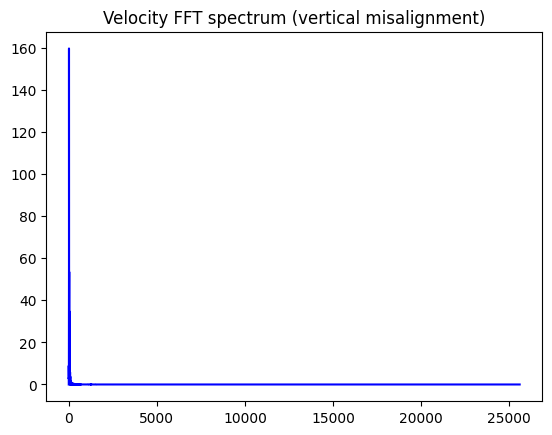

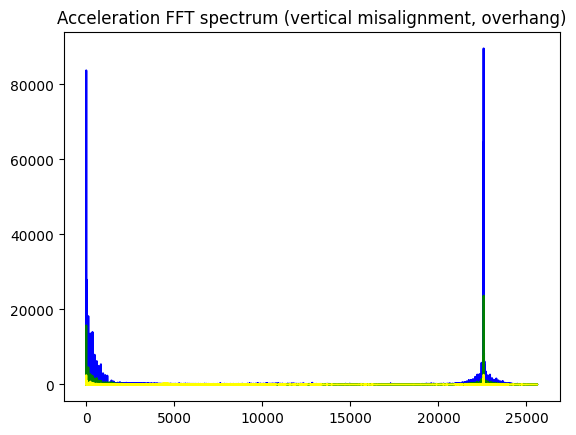

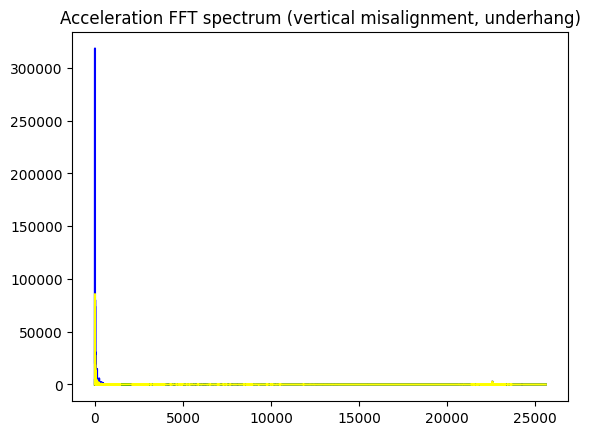

In [16]:
vel_fft_spectrum(df_vmis.iloc[:,0].values)
plt.title("Velocity FFT spectrum (vertical misalignment)")
plt.show()

accel_fft_spectrum(df_vmis.iloc[:,1].values, df_vmis.iloc[:,2].values, df_vmis.iloc[:,3].values, df_vmis.iloc[:,1].shape[0])
plt.title("Acceleration FFT spectrum (vertical misalignment, overhang)")
plt.show()

accel_fft_spectrum(df_vmis.iloc[:,4].values, df_vmis.iloc[:,5].values, df_vmis.iloc[:,6].values, df_vmis.iloc[:,4].shape[0])
plt.title("Acceleration FFT spectrum (vertical misalignment, underhang)")
plt.show()

In [17]:
freq = df_vmis.iloc[:, 0].values
rad_per_sec = freq * (2 * (np.pi / 60))
ang_vel = cumtrapz(y=rad_per_sec, dx=1 / SAMPLE_RATE, initial=0)
ang_vel_fft = rfft(ang_vel - np.mean(ang_vel))

uhang_x = df_vmis.iloc[:, 1].values
uhang_y = df_vmis.iloc[:, 2].values
uhang_z = df_vmis.iloc[:, 3].values
uhang_x_fft = rfft(uhang_x - np.mean(uhang_x))
uhang_y_fft = rfft(uhang_y - np.mean(uhang_y))
uhang_z_fft = rfft(uhang_z - np.mean(uhang_z))

ohang_x = df_vmis.iloc[:, 4].values
ohang_y = df_vmis.iloc[:, 5].values
ohang_z = df_vmis.iloc[:, 6].values
ohang_x_fft = rfft(ohang_x - np.mean(ohang_x))
ohang_y_fft = rfft(ohang_y - np.mean(ohang_y))
ohang_z_fft = rfft(ohang_z - np.mean(ohang_z))

n_samples = df_vmis.shape[0]
df_fft_vmis = pd.DataFrame()

df_fft_vmis['ang_vel_fft'] = np.abs(ang_vel_fft[:n_samples])

df_fft_vmis['uhang_x_fft'] = np.abs(uhang_x_fft[:n_samples])
df_fft_vmis['uhang_y_fft'] = np.abs(uhang_y_fft[:n_samples])
df_fft_vmis['uhang_z_fft'] = np.abs(uhang_z_fft[:n_samples])

df_fft_vmis['ohang_x_fft'] = np.abs(ohang_x_fft[:n_samples])
df_fft_vmis['ohang_y_fft'] = np.abs(ohang_y_fft[:n_samples])
df_fft_vmis['ohang_z_fft'] = np.abs(ohang_z_fft[:n_samples])

df_fft_vmis['fftfreq'] = rfftfreq(n_samples, 1 / SAMPLE_RATE)
df_fft_vmis['class'] = 2
df_fft_vmis

ang_vel_fft   uhang_x_fft   uhang_y_fft   uhang_z_fft   ohang_x_fft  \
0       7.631265e-15  5.947243e-12  3.028688e-12  1.998401e-14  1.923439e-11   
1       8.900178e+00  2.130640e+03  4.089540e+02  6.591364e+01  2.169962e+04   
2       5.515405e+00  1.615369e+03  4.019717e+02  5.208728e+01  2.067230e+04   
3       3.046071e+00  2.042082e+03  3.623882e+02  7.161790e+01  2.349034e+04   
4       1.958635e+00  4.403799e+02  2.606960e+02  2.292783e+01  3.327984e+04   
...              ...           ...           ...           ...           ...   
124996  4.110008e-04  8.070349e+00  1.406325e+01  8.199711e-01  9.770166e-01   
124997  4.110005e-04  3.828237e+01  1.199901e+01  1.334187e+00  8.267904e-01   
124998  4.110011e-04  3.573889e+01  2.754298e+00  1.954929e+00  3.795478e+00   
124999  4.110012e-04  1.589023e+01  1.753740e+00  5.636887e-01  8.539601e-01   
125000  4.110011e-04  1.314260e+01  9.262996e-01  6.201037e-01  2.138885e+00   

         ohang_y_fft   ohang_z_fft     fftfreq  class  
0       3.463896e-14  3.114842e-12      0.0000      2  
1       2.824823e+02  4.602607e+04      0.2048      2  
2       1.785442e+02  3.696440e+04      0.4096      2  
3       1.877505e+02  1.334152e+04      0.6144      2  
4       4.327543e+02  9.659259e+03      0.8192      2  
...              ...           ...         ...    ...  
124996  5.358189e-01  1.319611e+00  25599.1808      2  
124997  2.154790e+00  1.305273e+00  25599.3856      2  
124998  2.061080e+00  3.608708e+00  25599.5904      2  
124999  1.454755e+00  1.401686e+00  25599.7952      2  
125000  9.160961e+00  2.458033e+00  25600.0000      2  

[125001 rows x 9 columns]

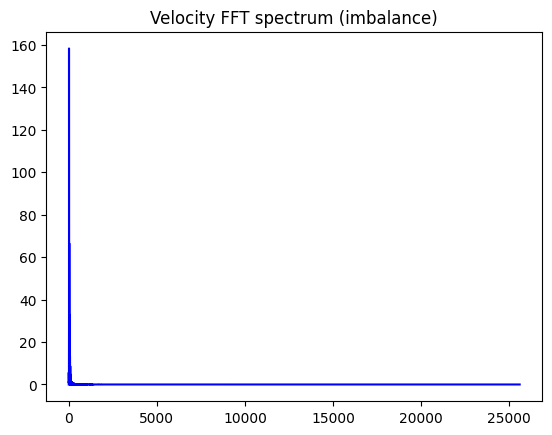

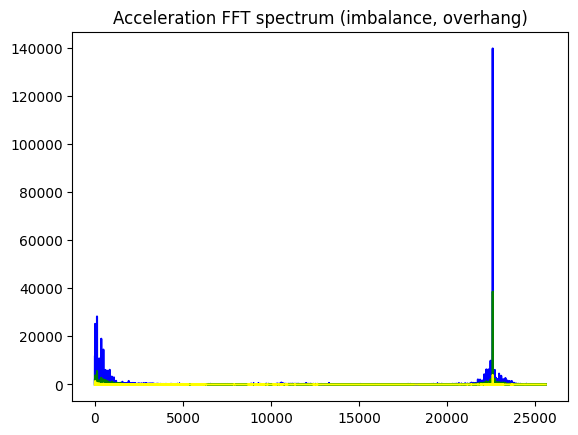

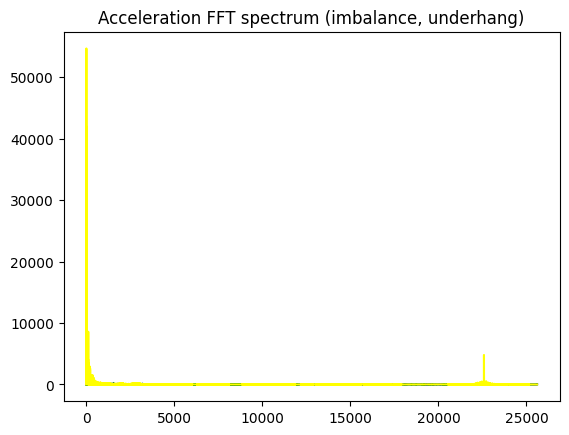

In [18]:
vel_fft_spectrum(df_imb.iloc[:,0].values)
plt.title("Velocity FFT spectrum (imbalance)")
plt.show()

accel_fft_spectrum(df_imb.iloc[:,1].values, df_imb.iloc[:,2].values, df_imb.iloc[:,3].values, df_imb.iloc[:,1].shape[0])
plt.title("Acceleration FFT spectrum (imbalance, overhang)")
plt.show()

accel_fft_spectrum(df_imb.iloc[:,4].values, df_imb.iloc[:,5].values, df_imb.iloc[:,6].values, df_imb.iloc[:,4].shape[0])
plt.title("Acceleration FFT spectrum (imbalance, underhang)")
plt.show()

In [19]:
freq = df_imb.iloc[:, 0].values
rad_per_sec = freq * (2 * (np.pi / 60))
ang_vel = cumtrapz(y=rad_per_sec, dx=1 / SAMPLE_RATE, initial=0)
ang_vel_fft = rfft(ang_vel - np.mean(ang_vel))

uhang_x = df_imb.iloc[:, 1].values
uhang_y = df_imb.iloc[:, 2].values
uhang_z = df_imb.iloc[:, 3].values
uhang_x_fft = rfft(uhang_x - np.mean(uhang_x))
uhang_y_fft = rfft(uhang_y - np.mean(uhang_y))
uhang_z_fft = rfft(uhang_z - np.mean(uhang_z))

ohang_x = df_imb.iloc[:, 4].values
ohang_y = df_imb.iloc[:, 5].values
ohang_z = df_imb.iloc[:, 6].values
ohang_x_fft = rfft(ohang_x - np.mean(ohang_x))
ohang_y_fft = rfft(ohang_y - np.mean(ohang_y))
ohang_z_fft = rfft(ohang_z - np.mean(ohang_z))

n_samples = df_imb.shape[0]
df_fft_imb = pd.DataFrame()

df_fft_imb['ang_vel_fft'] = np.abs(ang_vel_fft[:n_samples])

df_fft_imb['uhang_x_fft'] = np.abs(uhang_x_fft[:n_samples])
df_fft_imb['uhang_y_fft'] = np.abs(uhang_y_fft[:n_samples])
df_fft_imb['uhang_z_fft'] = np.abs(uhang_z_fft[:n_samples])

df_fft_imb['ohang_x_fft'] = np.abs(ohang_x_fft[:n_samples])
df_fft_imb['ohang_y_fft'] = np.abs(ohang_y_fft[:n_samples])
df_fft_imb['ohang_z_fft'] = np.abs(ohang_z_fft[:n_samples])

df_fft_imb['fftfreq'] = rfftfreq(n_samples, 1 / SAMPLE_RATE)
df_fft_imb['class'] = 3
df_fft_imb

ang_vel_fft   uhang_x_fft   uhang_y_fft   uhang_z_fft   ohang_x_fft  \
0       6.768132e-14  4.185097e-12  2.056133e-13  3.279599e-13  7.185363e-13   
1       5.616958e+00  2.885479e+02  1.294679e+02  3.134056e+01  2.880021e+02   
2       3.267536e+00  1.312630e+03  2.033362e+02  3.915489e+01  7.366276e+02   
3       4.122564e+00  8.341858e+02  1.973219e+02  2.925973e+01  1.213769e+03   
4       3.282044e+00  5.688473e+02  5.292140e+01  1.156509e+01  2.247428e+02   
...              ...           ...           ...           ...           ...   
124996  2.619994e-04  3.644089e+01  6.865488e+00  2.668505e+00  1.815601e+00   
124997  2.620012e-04  6.704803e+00  1.275731e+01  7.579776e-01  9.574617e-01   
124998  2.620003e-04  3.786288e+01  8.123243e+00  1.324751e+00  5.286516e-01   
124999  2.620004e-04  2.672466e+01  1.277779e+01  5.182623e-01  3.675717e-01   
125000  2.620002e-04  8.109265e+00  6.838335e+00  2.075241e-02  1.472939e+01   

         ohang_y_fft   ohang_z_fft     fftfreq  class  
0       5.506706e-14  5.167200e-12      0.0000      3  
1       2.752607e+01  1.149221e+04      0.2048      3  
2       1.861526e+02  1.153526e+04      0.4096      3  
3       2.786567e+02  2.593878e+04      0.6144      3  
4       2.429961e+01  8.952793e+03      0.8192      3  
...              ...           ...         ...    ...  
124996  2.074870e+00  3.062643e+00  25599.1808      3  
124997  4.816863e-01  2.134614e+00  25599.3856      3  
124998  6.814839e-01  3.908730e+00  25599.5904      3  
124999  3.278847e-01  7.951547e-01  25599.7952      3  
125000  1.553355e+01  9.088224e-01  25600.0000      3  

[125001 rows x 9 columns]

In [20]:
df_fft_general = pd.concat([df_fft_normal, df_fft_hmis, df_fft_vmis, df_fft_imb])
df_fft_general.reset_index(inplace=True, drop=True)
del df_normal
del df_hmis
del df_vmis
del df_imb
del df_fft_normal
del df_fft_hmis
del df_fft_vmis
del df_fft_imb
collect()
df_fft_general

ang_vel_fft   uhang_x_fft   uhang_y_fft   uhang_z_fft   ohang_x_fft  \
0       3.770638e-14  3.758771e-12  1.850964e-12  1.489919e-13  1.779910e-12   
1       5.556409e+00  7.527739e+02  6.554490e+01  1.561405e+01  2.123549e+04   
2       2.018688e+00  4.663129e+02  3.855406e+01  9.537433e+00  1.806313e+04   
3       3.377706e+00  2.038828e+02  3.335922e+01  3.331314e+00  1.626132e+04   
4       2.796448e+00  1.888168e+02  4.010503e+01  1.045659e+01  1.213880e+04   
...              ...           ...           ...           ...           ...   
499999  2.619994e-04  3.644089e+01  6.865488e+00  2.668505e+00  1.815601e+00   
500000  2.620012e-04  6.704803e+00  1.275731e+01  7.579776e-01  9.574617e-01   
500001  2.620003e-04  3.786288e+01  8.123243e+00  1.324751e+00  5.286516e-01   
500002  2.620004e-04  2.672466e+01  1.277779e+01  5.182623e-01  3.675717e-01   
500003  2.620002e-04  8.109265e+00  6.838335e+00  2.075241e-02  1.472939e+01   

         ohang_y_fft   ohang_z_fft     fftfreq  class  
0       9.769963e-15  1.326272e-12      0.0000      0  
1       5.131575e+01  1.120746e+04      0.2048      0  
2       7.927480e+01  9.896221e+03      0.4096      0  
3       9.321161e+01  5.844571e+03      0.6144      0  
4       4.212470e+01  4.858016e+03      0.8192      0  
...              ...           ...         ...    ...  
499999  2.074870e+00  3.062643e+00  25599.1808      3  
500000  4.816863e-01  2.134614e+00  25599.3856      3  
500001  6.814839e-01  3.908730e+00  25599.5904      3  
500002  3.278847e-01  7.951547e-01  25599.7952      3  
500003  1.553355e+01  9.088224e-01  25600.0000      3  

[500004 rows x 9 columns]

<h2>Model training</h2>

In [21]:
def get_all_file_paths(directory):
    file_paths = []
  
    for root, directories, files in walk(directory):
        for filename in files:
            filepath = join(root, filename)
            file_paths.append(filepath)
  
    return file_paths

def zip_file(path, file_paths):
    with ZipFile(path + '.zip','w') as zip:
        for file in file_paths:
            zip.write(file)

In [22]:
X_df_fft = df_fft_general.iloc[:,0:8]
y_df_fft = df_fft_general.iloc[:,8]
fft_split = StratifiedShuffleSplit(test_size=0.2, train_size=0.8, random_state=42)

for train_index, test_index in fft_split.split(X_df_fft, y_df_fft):
    fft_train_set = df_fft_general.loc[train_index]
    fft_test_set = df_fft_general.loc[test_index]
    
fft_strat_dist = fft_test_set['class'].value_counts() / len(fft_test_set)
print(f"Class distibution: {fft_strat_dist}")

X_train_fft = fft_train_set.iloc[:,0:8]
y_train_fft = fft_train_set.iloc[:,8]
X_test_fft = fft_test_set.iloc[:,0:8]
y_test_fft = fft_test_set.iloc[:,8]

print("\n--- Final Train-Test Sets Results ---")
print(f"Train set size: {fft_train_set.shape[0]}")
print(f"Test set size: {fft_test_set.shape[0]}")

Class distibution: class
2    0.250007
1    0.249998
3    0.249998
0    0.249998
Name: count, dtype: float64

--- Final Train-Test Sets Results ---
Train set size: 400003
Test set size: 100001


<h3>Gradient Boosted Tree</h3>

In [23]:
gbt_learner = ydf.GradientBoostedTreesLearner(label='class')
gbt_learner.cross_validation(df_fft_general)

I0000 00:00:1730493676.303743      24 dataset.cc:410] max_vocab_count = -1 for column class, the dictionary will not be pruned by size.
W0000 00:00:1730493676.343134      24 gradient_boosted_trees.cc:1841] "goss_alpha" set but "sampling_method" not equal to "GOSS".
W0000 00:00:1730493676.343160      24 gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
W0000 00:00:1730493676.343165      24 gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
No input feature explicitly specified. Using all the available input features.
The label "class" was removed from the input feature set.
Default loss set to MULTINOMIAL_LOG_LIKELIHOOD
Training gradient boosted tree on 450003 example(s) and 8 feature(s).
404852 examples used for training and 45151 examples used for validation
	num-trees:1 train-loss:1.171251 train-accuracy:0.751321 valid-loss:1.171805 valid-accuracy:0.749264
	num-trees:2 train-loss

Evaluation()

In [24]:
gbt_model = gbt_learner.train(fft_train_set)
gbt_model.describe()

Train model on 400003 examples


max_vocab_count = -1 for column class, the dictionary will not be pruned by size.
"goss_alpha" set but "sampling_method" not equal to "GOSS".
"goss_beta" set but "sampling_method" not equal to "GOSS".
"selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
Data spec:
Number of records: 400003
Number of columns: 9

Number of columns by type:
	NUMERICAL: 8 (88.8889%)
	CATEGORICAL: 1 (11.1111%)

Columns:

NUMERICAL: 8 (88.8889%)
	1: "ang_vel_fft" NUMERICAL mean:0.01285 min:3.77064e-14 max:158.392 sd:0.472892 dtype:DTYPE_FLOAT64
	2: "uhang_x_fft" NUMERICAL mean:92.1527 min:3.75877e-12 max:90017.5 sd:531.597 dtype:DTYPE_FLOAT64
	3: "uhang_y_fft" NUMERICAL mean:35.5252 min:2.05613e-13 max:24602.7 sd:138.281 dtype:DTYPE_FLOAT64
	4: "uhang_z_fft" NUMERICAL mean:10.2189 min:1.48992e-13 max:2748.94 sd:22.9709 dtype:DTYPE_FLOAT64
	5: "ohang_x_fft" NUMERICAL mean:30.5023 min:7.18536e-13 max:318515 sd:900.552 dtype:DTYPE_FLOAT64
	6: "ohang_y_fft" NUMERICAL mean:4.00547 m

Model trained in 0:03:30.557546


	num-trees:300 train-loss:0.211482 train-accuracy:0.909868 valid-loss:0.240914 valid-accuracy:0.892377
Truncates the model to 1196 tree(s) i.e. 299  iteration(s).
Final model num-trees:299 valid-loss:0.240896 valid-accuracy:0.892278


In [25]:
directory = './gbt_model'
tf_gbt_model = gbt_model.to_tensorflow_function()
tf.saved_model.save(tf_gbt_model, directory)
file_paths = get_all_file_paths(directory)
zip_file(directory, file_paths)

[INFO 24-11-01 21:23:12.8498 UTC kernel.cc:1233] Loading model from path /tmp/tmpp_l70cxv/ with prefix 3f8d1f41_
[INFO 24-11-01 21:23:13.0697 UTC decision_forest.cc:660] Model loaded with 1196 root(s), 64998 node(s), and 8 input feature(s).
[INFO 24-11-01 21:23:13.0698 UTC abstract_model.cc:1344] Engine "GradientBoostedTreesGeneric" built
[INFO 24-11-01 21:23:13.0698 UTC kernel.cc:1061] Use fast generic engine


<h3>Random Forest</h3>

In [26]:
rf_learner = ydf.RandomForestLearner(label='class')
rf_learner.cross_validation(df_fft_general)

No input feature explicitly specified. Using all the available input features.
The label "class" was removed from the input feature set.
Training random forest on 450003 example(s) and 8 feature(s).
Training of tree  1/300 (tree index:3) done accuracy:0.836658 logloss:5.88743
Training of tree  11/300 (tree index:8) done accuracy:0.848703 logloss:2.6705
Training of tree  21/300 (tree index:20) done accuracy:0.855162 logloss:1.63661
Training of tree  31/300 (tree index:30) done accuracy:0.857754 logloss:1.23709
Training of tree  41/300 (tree index:40) done accuracy:0.859223 logloss:1.04748
Training of tree  51/300 (tree index:50) done accuracy:0.859599 logloss:0.934315
Training of tree  61/300 (tree index:61) done accuracy:0.860488 logloss:0.838452
Training of tree  71/300 (tree index:70) done accuracy:0.861254 logloss:0.761655
Training of tree  81/300 (tree index:80) done accuracy:0.862088 logloss:0.71406
Training of tree  91/300 (tree index:90) done accuracy:0.862156 logloss:0.668088
T

Evaluation()

81 logloss:0.772283
Training of tree  81/300 (tree index:80) done accuracy:0.862103 logloss:0.721961
Training of tree  91/300 (tree index:90) done accuracy:0.862259 logloss:0.692847
Training of tree  101/300 (tree index:100) done accuracy:0.862339 logloss:0.664136
Training of tree  111/300 (tree index:110) done accuracy:0.862323 logloss:0.633766
Training of tree  121/300 (tree index:120) done accuracy:0.862477 logloss:0.611073
Training of tree  131/300 (tree index:130) done accuracy:0.862599 logloss:0.592594
Training of tree  141/300 (tree index:140) done accuracy:0.862586 logloss:0.574409
Training of tree  151/300 (tree index:150) done accuracy:0.862759 logloss:0.558194
Training of tree  161/300 (tree index:160) done accuracy:0.862817 logloss:0.539134
Training of tree  171/300 (tree index:170) done accuracy:0.863023 logloss:0.526037
Training of tree  181/300 (tree index:180) done accuracy:0.862912 logloss:0.509121
Training of tree  191/300 (tree index:190) done accuracy:0.863057 loglo

In [27]:
rf_model = rf_learner.train(fft_train_set)
rf_model.describe()

Train model on 400003 examples


max_vocab_count = -1 for column class, the dictionary will not be pruned by size.
Data spec:
Number of records: 400003
Number of columns: 9

Number of columns by type:
	NUMERICAL: 8 (88.8889%)
	CATEGORICAL: 1 (11.1111%)

Columns:

NUMERICAL: 8 (88.8889%)
	1: "ang_vel_fft" NUMERICAL mean:0.01285 min:3.77064e-14 max:158.392 sd:0.472892 dtype:DTYPE_FLOAT64
	2: "uhang_x_fft" NUMERICAL mean:92.1527 min:3.75877e-12 max:90017.5 sd:531.597 dtype:DTYPE_FLOAT64
	3: "uhang_y_fft" NUMERICAL mean:35.5252 min:2.05613e-13 max:24602.7 sd:138.281 dtype:DTYPE_FLOAT64
	4: "uhang_z_fft" NUMERICAL mean:10.2189 min:1.48992e-13 max:2748.94 sd:22.9709 dtype:DTYPE_FLOAT64
	5: "ohang_x_fft" NUMERICAL mean:30.5023 min:7.18536e-13 max:318515 sd:900.552 dtype:DTYPE_FLOAT64
	6: "ohang_y_fft" NUMERICAL mean:4.00547 min:9.76996e-15 max:24308.8 sd:51.997 dtype:DTYPE_FLOAT64
	7: "ohang_z_fft" NUMERICAL mean:20.6381 min:4.26326e-14 max:85681.2 sd:298.353 dtype:DTYPE_FLOAT64
	8: "fftfreq" NUMERICAL mean:12804.8 min:0 max

Model trained in 0:03:47.291783


In [28]:
directory = './rf_model'
tf_rf_model = rf_model.to_tensorflow_function()
tf.saved_model.save(tf_rf_model, directory)
file_paths = get_all_file_paths(directory)
zip_file(directory, file_paths)

[INFO 24-11-01 22:09:07.2208 UTC kernel.cc:1233] Loading model from path /tmp/tmpg6bixjzr/ with prefix 248f332d_
[INFO 24-11-01 22:09:14.5455 UTC decision_forest.cc:660] Model loaded with 300 root(s), 1991248 node(s), and 8 input feature(s).
[INFO 24-11-01 22:09:14.5456 UTC abstract_model.cc:1344] Engine "RandomForestGeneric" built
[INFO 24-11-01 22:09:14.5456 UTC kernel.cc:1061] Use fast generic engine


<h3>CART</h3>

In [29]:
cart_learner = ydf.CartLearner(label='class')
cart_learner.cross_validation(df_fft_general)

No input feature explicitly specified. Using all the available input features.
The label "class" was removed from the input feature set.
Training CART on 450003 example(s) and 8 feature(s).
5291 nodes before pruning. 1399 nodes after pruning.
Model loaded with 1 root(s), 1399 node(s), and 8 input feature(s).
Engine "RandomForestGeneric" built
Model loaded with 1 root(s), 1399 node(s), and 8 input feature(s).
No input feature explicitly specified. Using all the available input features.
The label "class" was removed from the input feature set.
Training CART on 450003 example(s) and 8 feature(s).
5231 nodes before pruning. 1457 nodes after pruning.
Model loaded with 1 root(s), 1457 node(s), and 8 input feature(s).
Model loaded with 1 root(s), 1457 node(s), and 8 input feature(s).
No input feature explicitly specified. Using all the available input features.
The label "class" was removed from the input feature set.
Training CART on 450003 example(s) and 8 feature(s).
5153 nodes before pru

Evaluation()

In [30]:
cart_model = cart_learner.train(fft_train_set)
cart_model.describe()

Train model on 400003 examples


max_vocab_count = -1 for column class, the dictionary will not be pruned by size.
Data spec:
Number of records: 400003
Number of columns: 9

Number of columns by type:
	NUMERICAL: 8 (88.8889%)
	CATEGORICAL: 1 (11.1111%)

Columns:

NUMERICAL: 8 (88.8889%)
	1: "ang_vel_fft" NUMERICAL mean:0.01285 min:3.77064e-14 max:158.392 sd:0.472892 dtype:DTYPE_FLOAT64
	2: "uhang_x_fft" NUMERICAL mean:92.1527 min:3.75877e-12 max:90017.5 sd:531.597 dtype:DTYPE_FLOAT64
	3: "uhang_y_fft" NUMERICAL mean:35.5252 min:2.05613e-13 max:24602.7 sd:138.281 dtype:DTYPE_FLOAT64
	4: "uhang_z_fft" NUMERICAL mean:10.2189 min:1.48992e-13 max:2748.94 sd:22.9709 dtype:DTYPE_FLOAT64
	5: "ohang_x_fft" NUMERICAL mean:30.5023 min:7.18536e-13 max:318515 sd:900.552 dtype:DTYPE_FLOAT64
	6: "ohang_y_fft" NUMERICAL mean:4.00547 min:9.76996e-15 max:24308.8 sd:51.997 dtype:DTYPE_FLOAT64
	7: "ohang_z_fft" NUMERICAL mean:20.6381 min:4.26326e-14 max:85681.2 sd:298.353 dtype:DTYPE_FLOAT64
	8: "fftfreq" NUMERICAL mean:12804.8 min:0 max

Model trained in 0:00:05.047902


4985 nodes before pruning. 1325 nodes after pruning.
Model loaded with 1 root(s), 1325 node(s), and 8 input feature(s).
Engine "RandomForestGeneric" built


In [31]:
directory = './cart_model'
tf_cart_model = cart_model.to_tensorflow_function()
tf.saved_model.save(tf_cart_model, directory)
file_paths = get_all_file_paths(directory)
zip_file(directory, file_paths)

[INFO 24-11-01 22:10:20.0152 UTC kernel.cc:1233] Loading model from path /tmp/tmpn0iepoqx/ with prefix 1e83ae73_
[INFO 24-11-01 22:10:20.0435 UTC decision_forest.cc:660] Model loaded with 1 root(s), 1325 node(s), and 8 input feature(s).
[INFO 24-11-01 22:10:20.0436 UTC abstract_model.cc:1344] Engine "RandomForestGeneric" built
[INFO 24-11-01 22:10:20.0436 UTC kernel.cc:1061] Use fast generic engine


<h3>CNN</h3>

(TODO)

<h3>Ensemble</h3>

(TODO)